In [1]:
import pandas as pd
import numpy as np

In [2]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

# ──────────────────────────────────────────────────────────────────────────────
# CONFIGURATION
# ──────────────────────────────────────────────────────────────────────────────
STEGO_CSV    = Path("csv/stego_final.csv")
IMAGES_DIR   = Path("Images")
BATCH_SIZE   = 64
IMG_SIZE     = 448
EPOCHS       = 10
LR           = 5e-6
WEIGHT_DECAY = 5e-4
EARLY_STOP   = 2
RANDOM_SEED  = 42

label_map = {"none": 0, "lsb": 1, "iwt": 1}

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# ──────────────────────────────────────────────────────────────────────────────
# 1) BUILD BINARY DATAFRAME
# ──────────────────────────────────────────────────────────────────────────────
df_stego = pd.read_csv(STEGO_CSV)
df_stego = df_stego[df_stego.method.isin(["lsb","iwt"])].copy()
df_stego["label"]    = df_stego["method"].map(label_map)
df_stego["filepath"] = df_stego["stego_path"]

n_stego = len(df_stego)
all_imgs = list(IMAGES_DIR.glob("*"))
used     = {Path(p).name for p in df_stego["filepath"]}
cands    = [str(p) for p in all_imgs if p.name not in used]
none_sample = random.sample(cands, min(n_stego, len(cands)))

df_none = pd.DataFrame({
    "filepath": none_sample,
    "label":    [0]*len(none_sample)
})

df = pd.concat([df_stego[["filepath","label"]], df_none], ignore_index=True)
df = df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

# ──────────────────────────────────────────────────────────────────────────────
# 2) SPLIT: 80/20 trainval/test, then 70/30 train/val
# ──────────────────────────────────────────────────────────────────────────────
trainval, test = train_test_split(
    df, test_size=0.20, stratify=df["label"], random_state=RANDOM_SEED
)
train, val = train_test_split(
    trainval, test_size=0.30, stratify=trainval["label"], random_state=RANDOM_SEED
)

print(f"Sizes → train: {len(train)}, val: {len(val)}, test: {len(test)}")
print("Train distribution:\n", train.label.value_counts(normalize=True))
print("Val   distribution:\n", val.label.value_counts(normalize=True))
print("Test  distribution:\n", test.label.value_counts(normalize=True))

# ──────────────────────────────────────────────────────────────────────────────
# 3) DATASET & DATALOADERS
# ──────────────────────────────────────────────────────────────────────────────
train_tf = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.3,0.3,0.3,0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485]*3, [0.229]*3),
    transforms.RandomErasing(p=0.4)
])
eval_tf = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(IMG_SIZE+32),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485]*3, [0.229]*3)
])

class BinaryStegoDataset(Dataset):
    def __init__(self, df, tf):
        self.df = df.reset_index(drop=True)
        self.tf = tf
    def __len__(self):
        return len(self.df)
    def __getitem__(self, i):
        row = self.df.iloc[i]
        img = Image.open(row.filepath).convert("RGB")
        return self.tf(img), int(row.label)

train_ds = BinaryStegoDataset(train, train_tf)
val_ds   = BinaryStegoDataset(val,   eval_tf)
test_ds  = BinaryStegoDataset(test,  eval_tf)

train_ld = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
val_ld   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_ld  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# ──────────────────────────────────────────────────────────────────────────────
# 4) MODEL SETUP: FREEZE BACKBONE, UNFREEZE layer4 & HEAD
# ──────────────────────────────────────────────────────────────────────────────
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
model  = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

# … after loading ResNet50 …
for p in model.parameters():
    p.requires_grad = False

# unfreeze the last two residual blocks
for p in model.layer3.parameters():
    p.requires_grad = True
for p in model.layer4.parameters():
    p.requires_grad = True

# rebuild the head
in_feats = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(in_feats, 2)
)
model = model.to(device)


model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LR, weight_decay=WEIGHT_DECAY
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", patience=1, factor=0.5
)



Sizes → train: 2124, val: 911, test: 759
Train distribution:
 label
0    0.5
1    0.5
Name: proportion, dtype: float64
Val   distribution:
 label
1    0.500549
0    0.499451
Name: proportion, dtype: float64
Test  distribution:
 label
0    0.500659
1    0.499341
Name: proportion, dtype: float64


/home/nitinjha/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [3]:
# ──────────────────────────────────────────────────────────────────────────────
# 5) TRAIN/VAL LOOP WITH EARLY STOPPING
# ──────────────────────────────────────────────────────────────────────────────
best_val, patience = float("inf"), 0
train_losses, val_losses = [], []

for epoch in range(1, EPOCHS+1):
    # train
    model.train()
    train_loss = 0.0
    for imgs, lbls in train_ld:
        imgs, lbls = imgs.to(device), lbls.to(device)
        optimizer.zero_grad()
        out  = model(imgs)
        loss = criterion(out, lbls)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * imgs.size(0)
    train_loss /= len(train_ds)
    train_losses.append(train_loss)

    # val
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, lbls in val_ld:
            imgs, lbls = imgs.to(device), lbls.to(device)
            out  = model(imgs)
            loss = criterion(out, lbls)
            val_loss += loss.item() * imgs.size(0)
    val_loss /= len(val_ds)
    val_losses.append(val_loss)

    scheduler.step(val_loss)
    print(f"Epoch {epoch}/{EPOCHS} → train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")





Epoch 1/10 → train_loss=0.6920, val_loss=0.6938
Epoch 2/10 → train_loss=0.6945, val_loss=0.6927
Epoch 3/10 → train_loss=0.6935, val_loss=0.6929
Epoch 4/10 → train_loss=0.6955, val_loss=0.6930
Epoch 5/10 → train_loss=0.6921, val_loss=0.6931
Epoch 6/10 → train_loss=0.6905, val_loss=0.6932
Epoch 7/10 → train_loss=0.6946, val_loss=0.6932
Epoch 8/10 → train_loss=0.6917, val_loss=0.6930
Epoch 9/10 → train_loss=0.6931, val_loss=0.6932
Epoch 10/10 → train_loss=0.6933, val_loss=0.6930


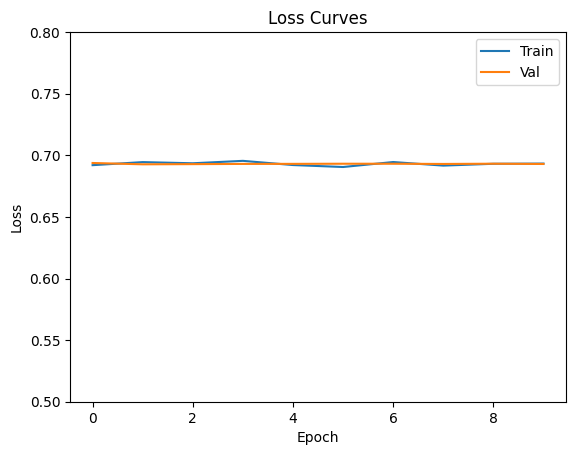

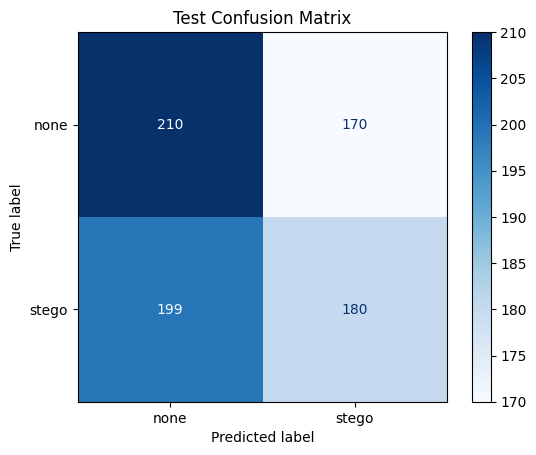

In [7]:
# ──────────────────────────────────────────────────────────────────────────────
# 6) PLOT LOSS CURVES
# ──────────────────────────────────────────────────────────────────────────────
plt.plot(train_losses, label="Train")
plt.plot(val_losses,   label="Val")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.ylim(0.5, 0.8)
plt.legend(); plt.title("Loss Curves")
plt.show()

# ──────────────────────────────────────────────────────────────────────────────
# 7) TEST & CONFUSION MATRIX
# ──────────────────────────────────────────────────────────────────────────────
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, lbls in test_ld:
        imgs = imgs.to(device)
        out  = model(imgs)
        preds= out.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(lbls.numpy())

cm = confusion_matrix(all_labels, all_preds, labels=[0,1])
disp = ConfusionMatrixDisplay(cm, display_labels=["none","stego"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Test Confusion Matrix")
plt.show()


In [5]:
from sklearn.metrics import classification_report, accuracy_score

# … after your test loop that builds all_preds and all_labels …

acc = accuracy_score(all_labels, all_preds)
print(f"Test accuracy: {acc:.4f}\n")

print("Detailed classification report:")
print(classification_report(all_labels, all_preds,
      target_names=["none","stego"]))


Test accuracy: 0.5138

Detailed classification report:
              precision    recall  f1-score   support

        none       0.51      0.55      0.53       380
       stego       0.51      0.47      0.49       379

    accuracy                           0.51       759
   macro avg       0.51      0.51      0.51       759
weighted avg       0.51      0.51      0.51       759

